Energy Consumption Prediction for Energy4Climate
=======================

In [9]:
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

import warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
warnings.filterwarnings('ignore')



## 1. Data Processing

#### 1.1 Data Loading
We will load the data that is in .csv format. We choose the columns that interest us and organize the data by date. We also fill in missing data with the previous value so as not to cause any errors in the creation of the model

In [10]:
#df = pd.read_csv('DrahiX_Data.csv', usecols=[0,5, 6,7,8,21,24], index_col=0, parse_dates=True, nrows = 135000)
df = pd.read_csv('New_Data.csv',index_col=0, parse_dates=True)
df = df.fillna(method='ffill')
df.keys()

Index(['gps-drahix-ag604', 'gps-drahix-ag605', 'gps-drahix-ag606', ' Total',
       'AirTemp', 'rh', 'TGBT'],
      dtype='object')

#### 1.2 Data Resampling

We will reorganize the loaded data in 15 minute intervals and add new features related to date and time. 

In [11]:
df = df.resample('15Min').mean()
df['day of the week'] = df.index.dayofweek
df['day of the year'] = df.index.dayofyear
df['hour of the day'] = df.index.hour
df['minute of the hour'] = df.index.minute
#df["Consumption"] = df['T1']+df['T2']+df['T3']+df['T4']
df["Consumption"] = df["TGBT"]

#### 1.3 Selection of Features and Targets 

After loading and reorganizing the data we can select the features that are useful for creating the model and the variables that will be predicted 

In [12]:
features = ['day of the week','day of the year','hour of the day','minute of the hour', 'AirTemp','rh']#, 'wd', 'ws','rh', 'rain']
labels   = ["Consumption"]
inputs   = features + labels
df = df[inputs]

num_features = len(features)
num_labels = len(labels)
num_inputs = num_features + num_labels

df.head()

,day of the week,day of the year,hour of the day,minute of the hour,AirTemp,rh,Consumption
Date and time,,,,,,,
2020-01-17 13:45:00+00:00,4,17,13,45,9.74,60.29,15731.54
2020-01-17 14:00:00+00:00,4,17,14,0,9.69,60.97,19330.38
2020-01-17 14:15:00+00:00,4,17,14,15,9.82,60.58,18874.84
2020-01-17 14:30:00+00:00,4,17,14,30,9.80,60.12,17677.85
2020-01-17 14:45:00+00:00,4,17,14,45,9.78,60.34,16604.97


#### 1.4 Data normalization 

Now we are going to normalize the data we have in the range between -1 and 1. These data are normalized independently between them and this facilitates the prediction by the model. 

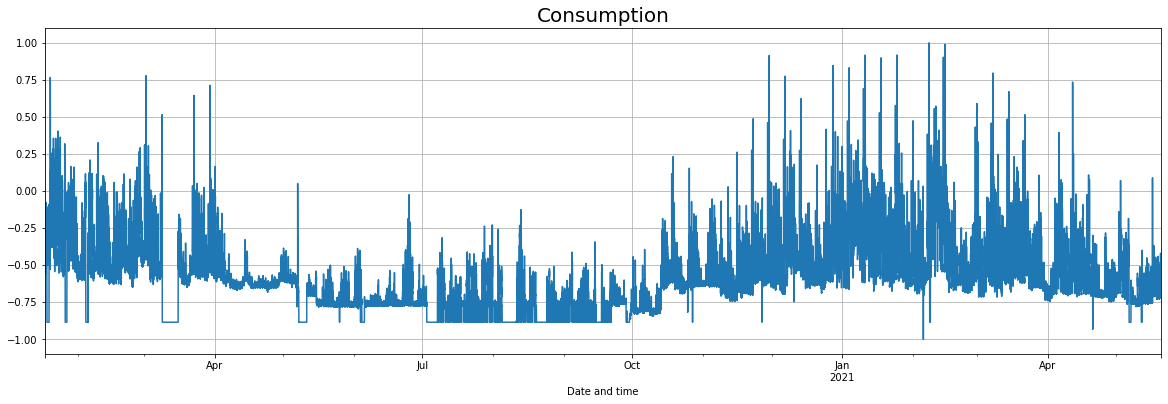

In [15]:
scaler = MinMaxScaler(feature_range=(-1, 1))
df_scaled = pd.DataFrame(scaler.fit_transform(df.values), columns=df.columns, index=df.index)

for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 6))
    ax = fig.add_subplot(111)
    df_scaled[labels[i]].plot(ax=ax)
    plt.title(labels[i], fontsize=20)
    plt.grid(True)
    plt.show()

#### 1.5 Data Division for Testing and Learning 

In [16]:
def split_data(data, test_size=0.25):
    """
    splits data to training and testing parts
    """
    ntest = int(round(len(data) * (1 - test_size)))
    
    df_train, df_test = data.iloc[:ntest], data.iloc[ntest:]
    
    return df_train, df_test


In [17]:
df_train, df_test = split_data(df_scaled, test_size=0.15)

x_train_scaled = np.asarray(df_train[features])
x_test_scaled = np.asarray(df_test[features])
y_test_scaled = np.asarray(df_test[labels])
y_train_scaled = np.asarray(df_train[labels])

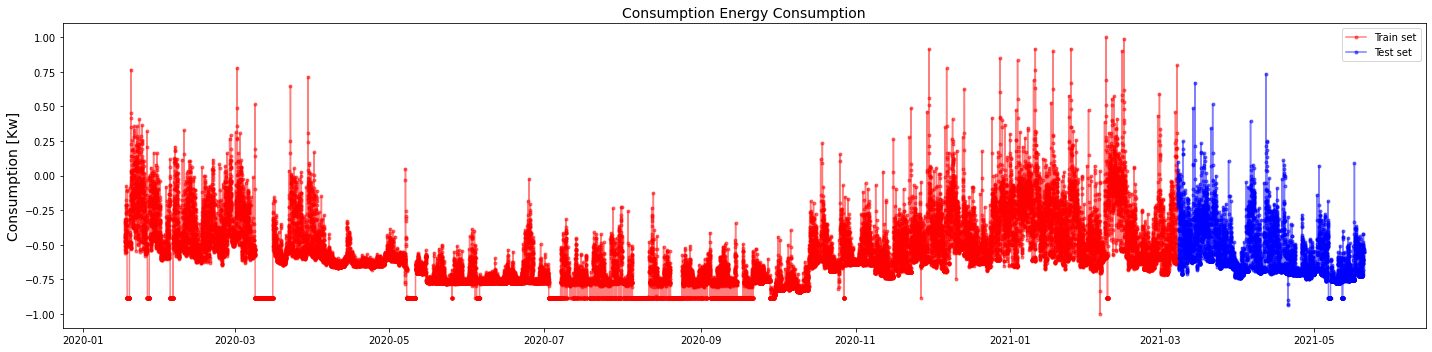

Total Data Size  :46945
Test Data Size  :7042
Train Data Size :39903


In [18]:
    
num_test = len(df_test)
num_train = len(df_train)
num_total = len(df)


split_index = num_train
X_train_values  = df[:split_index] # get the datetime values of X_train
X_test_values = df[split_index:]

for i in range(len(labels)):
    plt.figure(figsize=(20,5))
    plt.plot(X_train_values.index, np.stack(y_train_scaled,axis=-1)[i], '.-', color='red', label='Train set', alpha=0.5)
    plt.plot(X_test_values.index, np.stack(y_test_scaled,axis=-1)[i], '.-', color='blue', label='Test set', alpha=0.5)
    plt.legend()
    plt.ylabel('Consumption [Kw]', fontsize=14)
    plt.title(labels[i]+' Energy Consumption', fontsize=14)
    plt.tight_layout()
    plt.show()
    

print(f'Total Data Size  :{len(df)}\n'+
f'Test Data Size  :{len(df_test)}\n'+
f'Train Data Size :{len(df_train)}')

#### 1.6 Batch Creation

In [19]:
def batch_generator(batch_size, sequence_length, num_features, num_labels, num_test, x, y):
    """
    Generator function for creating random batches of training-data.
    """

    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, num_features)
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, num_labels)
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)
   
        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            if num_test<sequence_length:
                print("there will be a problem test too short", num_test)
            idx = np.random.randint(num_test - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = x[idx:idx+sequence_length]
            y_batch[i] = y[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)


X Batch Shape :  (10, 24, 6)
Y Batch Shape :  (10, 24, 6)


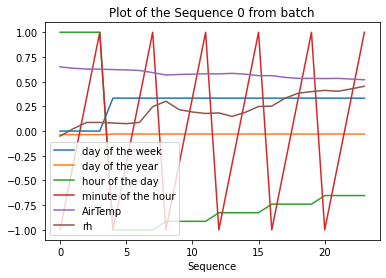

In [20]:
batch_size = 10
sequence_length = int(60/15*6)  

generator     = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_train, x_train_scaled, y_train_scaled)
testgenerator = batch_generator(batch_size, sequence_length, num_features, 
                                num_labels, num_test,  x_test_scaled,  y_test_scaled)

x_batch, y_batch = next(generator)

print(f'X Batch Shape :  {x_batch.shape}')
print(f'Y Batch Shape :  {x_batch.shape}')

seq = x_batch[0, :, :]
plt.plot(seq)
plt.xlabel('Sequence')
plt.legend(features)
plt.title(f'Plot of the Sequence 0 from batch')
plt.show()

## 2. LSTM Model

In [27]:
from tensorflow.keras.utils import Progbar


num_neurons = 150  # was 10
learning_rate = 0.001
num_layers = 5
num_iter = 1
keep_prob = 0.2

next(testgenerator)
graph = tf.Graph()

with graph.as_default():
    x = tf.placeholder(tf.float32, [None, sequence_length, num_features], name='x')
    y = tf.placeholder(tf.float32, [None, sequence_length, num_labels], name="y") 
    
    def get_a_cell(lstm_size, keep_prob):
            lstm = tf.nn.rnn_cell.LSTMCell(lstm_size)
            drop = tf.nn.rnn_cell.DropoutWrapper(lstm, output_keep_prob=keep_prob)
            return drop
    
with graph.as_default():
    with tf.name_scope('lstm'):
        cell = tf.nn.rnn_cell.MultiRNNCell([get_a_cell(num_neurons, 1-keep_prob) for _ in range(num_layers)])


    outputs, current_state = tf.nn.dynamic_rnn(cell, x, dtype=tf.float32)

    # from another program 
    stacked_rnn_output = tf.reshape(outputs, [-1, num_neurons])           #change the form into a tensor
    stacked_outputs = tf.layers.dense(stacked_rnn_output, num_labels) 
    #stacked_outputs = tf.layers.dense(stacked_outputs, num_labels)#specify the type of layer (dense)
    outputs = tf.reshape(stacked_outputs, [-1, sequence_length, num_labels],name="op_to_restore")          #shape of results

    loss = tf.losses.mean_squared_error(y, outputs)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
     
    train = optimizer.minimize(loss)
    
    init = tf.global_variables_initializer()
    
    saver = tf.train.Saver()
    
    with tf.Session(graph=graph) as sess:
        sess.run(init)
        histogram_summary = tf.summary.scalar('MSE', loss)
        merged = tf.summary.merge_all()
        writer = tf.summary.FileWriter('./graphs', sess.graph)
        progbar = Progbar(num_iter)
        
        saver = tf.train.import_meta_graph('Model'+str(24)+'/my_test_model-1000.meta')
        saver.restore(sess,tf.train.latest_checkpoint('./Model'+str(24)+'/'))
        
        for iter in range(num_iter):
            x_batch, y_batch = next(generator)
            _current_state, l = sess.run([current_state, train], feed_dict={x: x_batch, y: y_batch})
            histogram_summary = tf.summary.histogram('My_histogram_summary', loss)
            res_sum = sess.run(merged, feed_dict={x: x_batch, y: y_batch})   
            mse = loss.eval(feed_dict={x: x_batch, y: y_batch})
            writer.add_summary(res_sum, iter)
            progbar.update(iter, values=[('MSE', mse)])
            
            
        saver.save(sess, 'my_test_model',global_step=1000)
            
        x_btest, ybtest = next(testgenerator)
        y_pred = sess.run(outputs, feed_dict={x: x_btest})

        ind = (len(x_test_scaled)//(sequence_length))*sequence_length
        x_test_tensor = x_test_scaled[0:ind].reshape([-1, sequence_length, num_features])
        y_model = sess.run(outputs, feed_dict={x: x_test_tensor})  


    

INFO:tensorflow:Restoring parameters from ./Model24/my_test_model-1000
0/1 [..............................] - ETA: 0s - MSE: 0.0000e+00

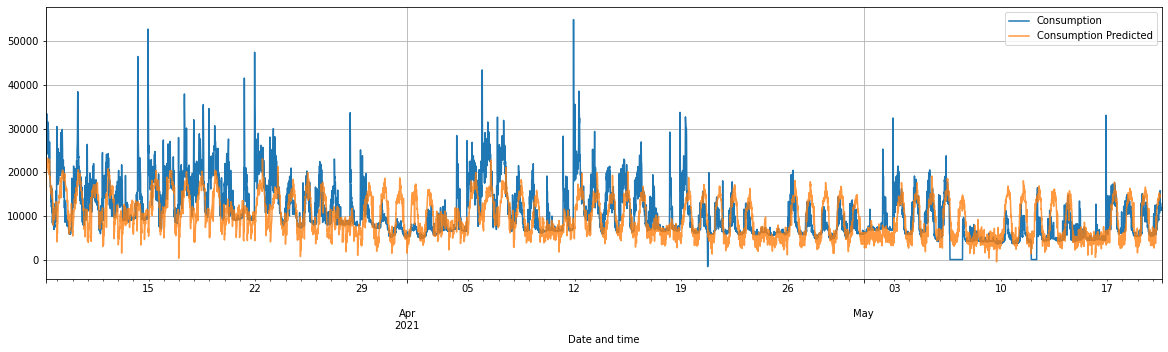

In [28]:
y_test = y_model.reshape(-1, num_labels)

scaler.fit(df[labels])
DF = pd.DataFrame(scaler.inverse_transform(y_test), index=df_test.iloc[0:ind].index , columns=labels)



for i in range(len(labels)):
    fig = plt.figure(figsize=(20, 5))
    df[labels[i]].iloc[num_train:].plot()
    DF[labels[i]].plot( label=labels[i]+' Predicted',alpha=0.8)
    plt.legend()
    plt.grid()
    plt.show()


In [29]:
from math import sqrt
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1))
print('MSE : %.3f' % mse)
rmse = sqrt(mean_squared_error(y_pred.reshape(-1,1), ybtest.reshape(-1,1)))
print('RMSE : %.3f' % rmse)

MSE : 0.021
RMSE : 0.145
